In [1]:
import numpy as np
import matplotlib.pyplot as plt
from casadi import *
from copy import *
import scipy.io
from numpy.random import default_rng
import torch
import math

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.38358911   0.0336062   -0.02886751]
 [-14.55998006   0.77391889  -0.52894851]
 [ 12.65708651   1.96152425  -1.4040423 ]]
B:  [[ 2.59916420e+00 -1.87379983e-01]
 [ 4.52995744e+02  4.98472583e+02]
 [ 6.58098533e+02  5.31717950e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
20.0  target penalty applied and exists

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Pub

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times


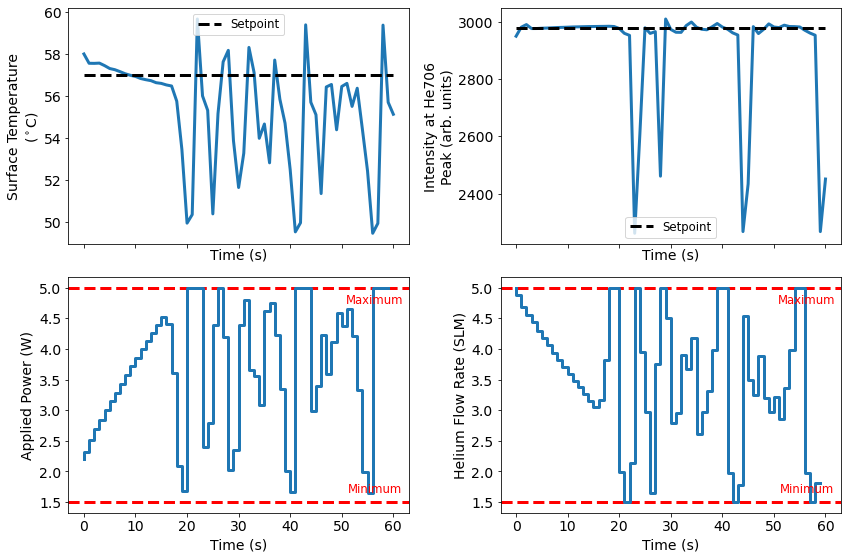

In [2]:
# import custom code
from config.my_system import get_prob_info
from utils.controller import OffsetFreeMPC, NominalMPC
from utils.simulation import Simulation
from utils.observer import EKF

def run_mpc(perc, plt_fig=False):
    # user inputs and options
    ts = 1.0 # sampling time, ensure it is the same as the model used
    Nsim = 60 # set the simulation horizon
    control_model_file = './models/APPJmodel_TEOS_UCB_LAM_modord3.mat'
    plant_model_file = './models/APPJmodel_TEOS_UCB_LAM_modord3.mat'

    Fontsize = 14 # default font size for plots
    Lwidth = 3 # default line width for plots
    lines = {'linewidth' : Lwidth}
    plt.rc('lines', **lines)
    font = {'family' : 'serif', 'serif'  : 'Times', 'size'   : Fontsize}
    plt.rc('font', **font)  # pass in the font dict as kwargs

    # [perc1, perc2, eps, seed] = perc ==> applying changes to A and B for plant
    
    # get problem information
    prob_info = get_prob_info(
        plant_model_file=plant_model_file, 
        control_model_file=control_model_file,
        perc=perc,
        filter_val=None, 
        mpc_type='offsetfree',
        )
    
    ts = prob_info['ts']
    xss = prob_info['xss']
    uss = prob_info['uss']
    xssp = prob_info['xssp']
    ussp = prob_info['ussp']
    x_min = prob_info['x_min']
    x_max = prob_info['x_max']
    u_min = prob_info['u_min']
    u_max = prob_info['u_max']
    
    print(prob_info['target_penalty'], " target penalty applied and exists")
    
    # get controller
    c = OffsetFreeMPC(prob_info)
    c.get_mpc()
    c.set_parameters([np.zeros((3,)), np.zeros((1,1)), np.zeros((1,1))])
    res, feas = c.solve_mpc()
    
    # get observer
    ekf = EKF(prob_info)
    ekf.get_observer()
    
    ## run closed loop simulation using MPC
    sim = Simulation(Nsim)
    sim.load_prob_info(prob_info)
    sim_data = sim.run_closed_loop(c, observer=ekf, offset=True, )
    
    ######### COLLECTING DATA ######### 
    ctime = sim_data['ctime']
    Yrefplot = sim_data['Yrefsim']
    Tref = Yrefplot[0,:] + xssp[0]
    I706ref = Yrefplot[1,:] + xssp[1]
    
    Tplot = sim_data['Ysim'][0,:] + xssp[0] # Temp
    I706 = sim_data['Ysim'][1,:] + xssp[1] # Intensity
    Pplot = sim_data['Usim'][0,:] + ussp[0] # Power
    qplot = sim_data['Usim'][1,:] + ussp[1] # Flowrate
    
    ######### PLOTTING ###########
    if plt_fig:
        fig, axes = plt.subplots(2,2, sharex=True, figsize=(12,8))
        
        axes[0,0].plot(np.arange(len(Tplot))*ts, Tplot)
        axes[0,0].plot(np.arange(len(Tref))*ts, Tref, 'k--', label='Setpoint')
        axes[0,0].legend(fontsize='small', loc='upper center')
        axes[0,0].set_xlabel('Time (s)')
        axes[0,0].set_ylabel('Surface Temperature\n('+r'$^\circ$'+'C)')

        axes[0,1].plot(np.arange(len(I706))*ts, I706)
        axes[0,1].plot(np.arange(len(I706))*ts, I706ref, 'k--', label='Setpoint')
        axes[0,1].legend(fontsize='small', loc='lower center')
        axes[0,1].set_xlabel('Time (s)')
        axes[0,1].set_ylabel('Intensity at He706\nPeak (arb. units)')

        axes[1,0].axhline(u_max[0]+uss[0], color='r', ls='--')
        axes[1,0].text(0.9, 0.9, 'Maximum', fontsize='small',
                       horizontalalignment='center',
                       verticalalignment='center', 
                       transform=axes[1,0].transAxes,
                       color='r',
                       )
        axes[1,0].axhline(u_min[0]+uss[0], color='r', ls='--')
        axes[1,0].text(0.9, 0.1, 'Minimum', fontsize='small',
                       horizontalalignment='center',
                       verticalalignment='center', 
                       transform=axes[1,0].transAxes,
                       color='r',
                       )
        axes[1,0].step(np.arange(len(Pplot))*ts, Pplot)
        axes[1,0].set_xlabel('Time (s)')
        axes[1,0].set_ylabel('Applied Power (W)')

        axes[1,1].axhline(u_max[1]+uss[1], color='r', ls='--')
        axes[1,1].text(0.9, 0.9, 'Maximum', fontsize='small',
                       horizontalalignment='center',
                       verticalalignment='center', 
                       transform=axes[1,1].transAxes,
                       color='r',
                       )
        axes[1,1].axhline(u_min[1]+uss[1], color='r', ls='--')
        axes[1,1].text(0.9, 0.1, 'Minimum', fontsize='small',
                       horizontalalignment='center',
                       verticalalignment='center', 
                       transform=axes[1,1].transAxes,
                       color='r',
                       )
        axes[1,1].step(np.arange(len(qplot))*ts, qplot)
        axes[1,1].set_xlabel('Time (s)')
        axes[1,1].set_ylabel('Helium Flow Rate (SLM)')

        plt.tight_layout()
        plt.show()
        
    # Trajectory of the measurable variables
    Temp_traj = Tplot[:Nsim+1]
    Intensity_traj = I706[:Nsim+1]

    # TODO: automate constraint violation for larger number of measurable variables
    Temp_violation = np.sum(Tref - Temp_traj)**2
    Intensity_violation = np.sum(I706ref - Intensity_traj)**2
    
    return Temp_violation, Intensity_violation

perc1, perc2, eps, seed = 0.03, 0.02, 0., 2500 
perc = [perc1, perc2, eps, seed]
T, I = run_mpc(perc, plt_fig=True)

0.0   0.0 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
20.0  target penalty applied and exists
Using a MPC.


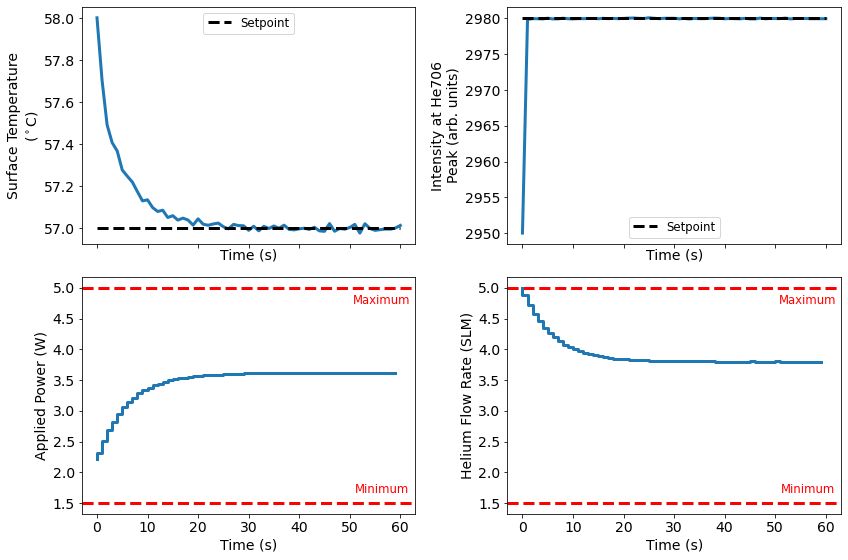



0.0   0.01 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.58667425e+00 -1.86228389e-01]
 [ 4.50505320e+02  4.95050149e+02]
 [ 6.51966136e+02  5.30210103e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
20.0  target penalty applied and exists
Using a MPC.


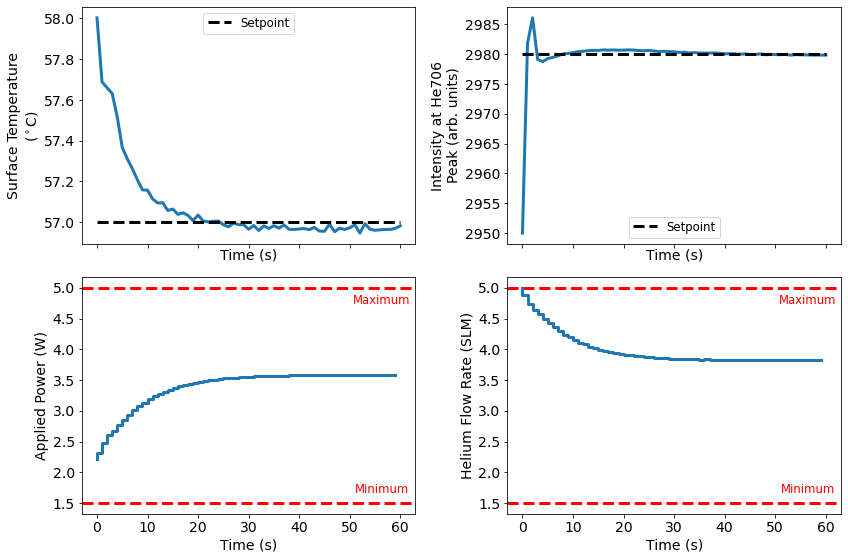



0.0   0.02 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.59916420e+00 -1.87379983e-01]
 [ 4.52995744e+02  4.98472583e+02]
 [ 6.58098533e+02  5.31717950e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
20.0  target penalty applied and exists
Using a MPC.


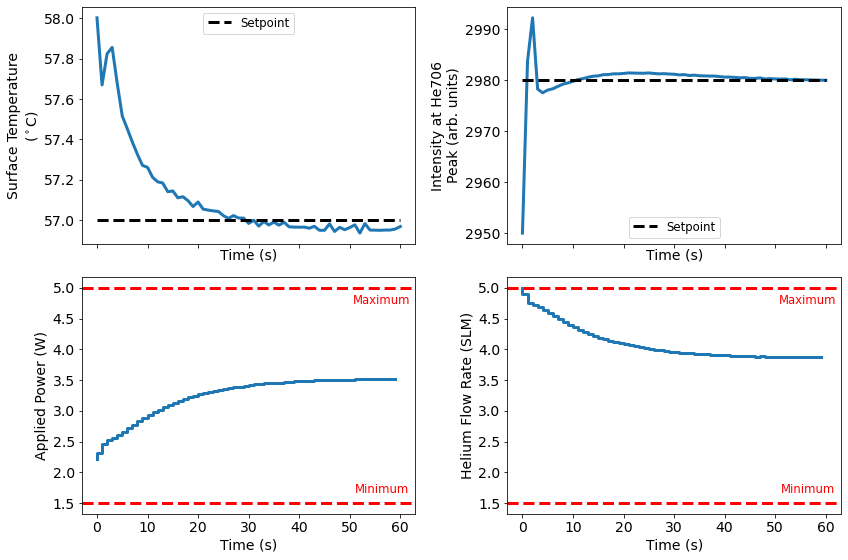



0.0   0.03 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.61165416e+00 -1.88531577e-01]
 [ 4.55486167e+02  5.01895017e+02]
 [ 6.64230930e+02  5.33225798e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
20.0  target penalty applied and exists
Using a MPC.


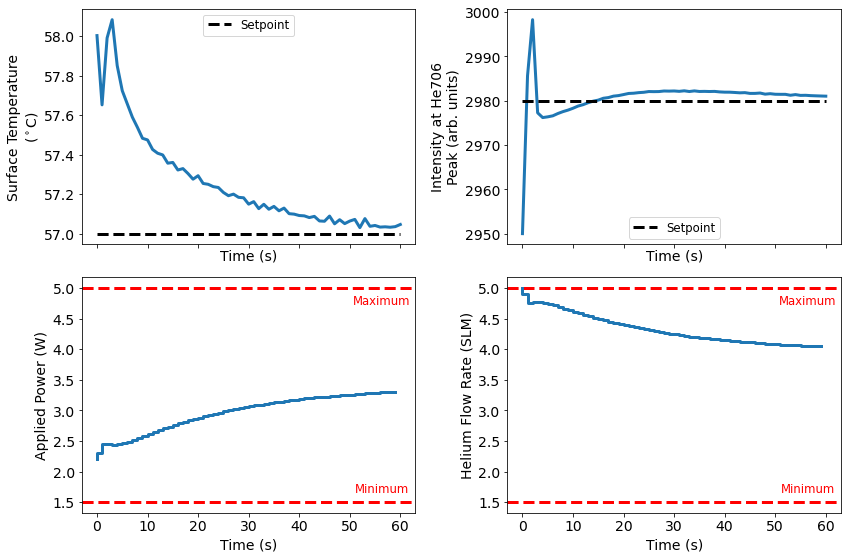



0.0   0.04 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.62414411e+00 -1.89683172e-01]
 [ 4.57976591e+02  5.05317451e+02]
 [ 6.70363327e+02  5.34733645e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
20.0  target penalty applied and exists
Using a MPC.
Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:157:
.../casadi/core/optistack_internal.cpp:998: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use o

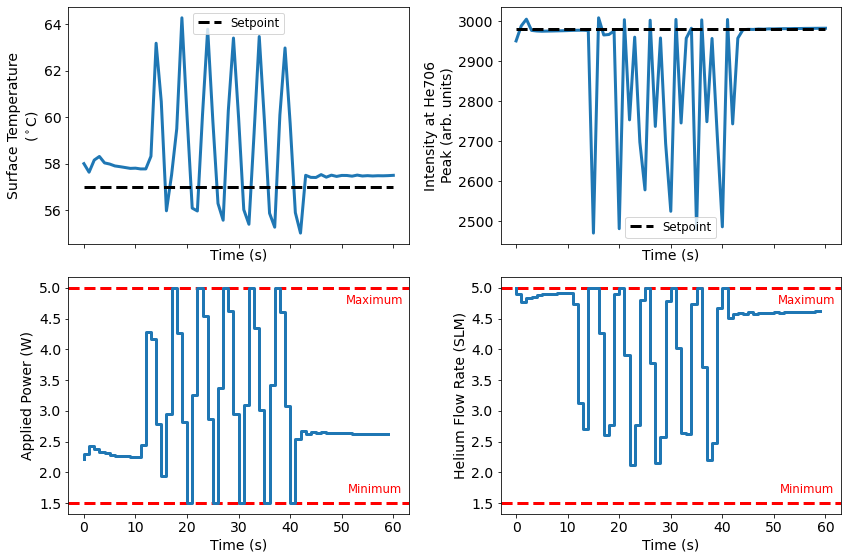



0.0   0.05 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.63663406e+00 -1.90834766e-01]
 [ 4.60467014e+02  5.08739885e+02]
 [ 6.76495724e+02  5.36241492e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
20.0  target penalty applied and exists
Using a MPC.
Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:157:
.../casadi/core/optistack_internal.cpp:998: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use o

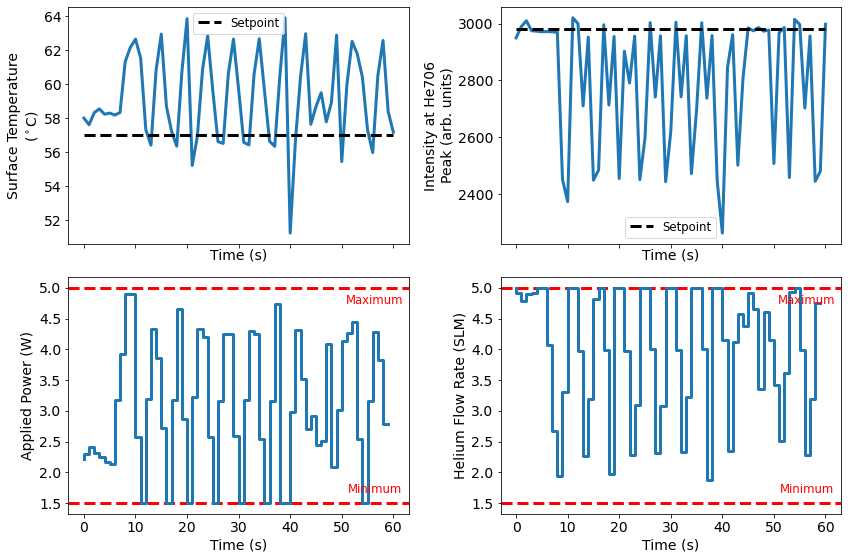



0.01   0.0 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.39559778   0.03360627  -0.02838704]
 [-14.47967377   0.7789153   -0.52600742]
 [ 12.59038939   1.98638335  -1.42915199]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
20.0  target penalty applied and exists
Using a MPC.


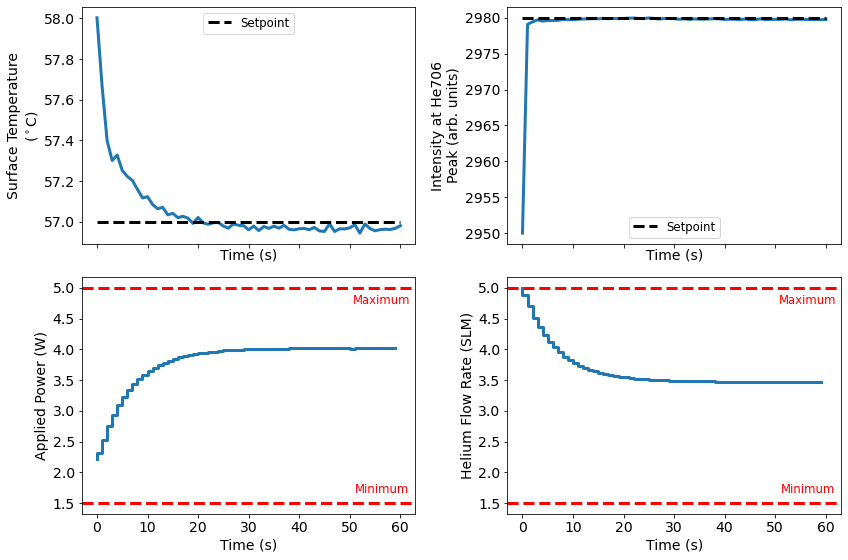



0.01   0.01 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.39559778   0.03360627  -0.02838704]
 [-14.47967377   0.7789153   -0.52600742]
 [ 12.59038939   1.98638335  -1.42915199]]
B:  [[ 2.58667425e+00 -1.86228389e-01]
 [ 4.50505320e+02  4.95050149e+02]
 [ 6.51966136e+02  5.30210103e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
20.0  target penalty applied and exists
Using a MPC.


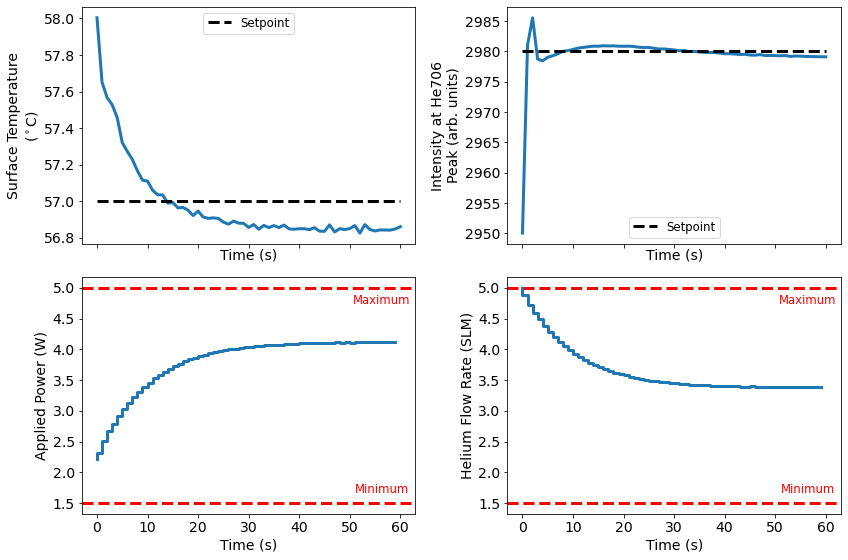



0.01   0.02 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.39559778   0.03360627  -0.02838704]
 [-14.47967377   0.7789153   -0.52600742]
 [ 12.59038939   1.98638335  -1.42915199]]
B:  [[ 2.59916420e+00 -1.87379983e-01]
 [ 4.52995744e+02  4.98472583e+02]
 [ 6.58098533e+02  5.31717950e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
20.0  target penalty applied and exists
Using a MPC.


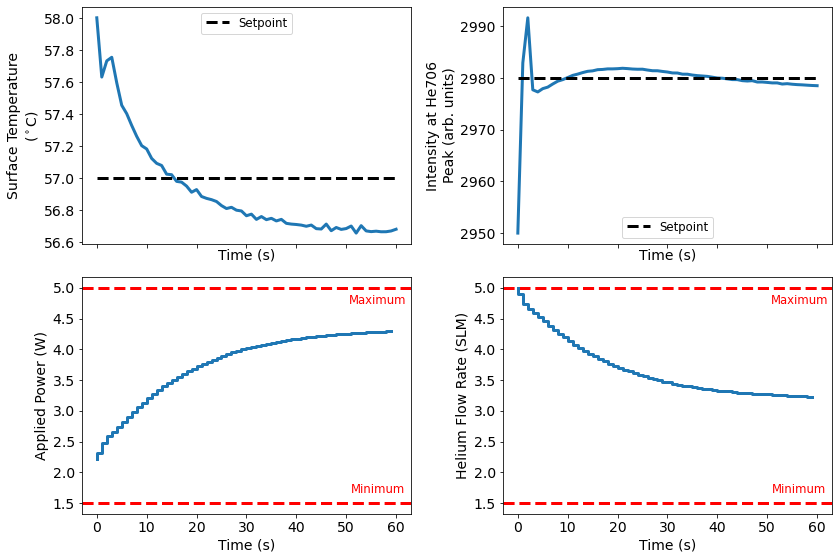



0.01   0.03 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.39559778   0.03360627  -0.02838704]
 [-14.47967377   0.7789153   -0.52600742]
 [ 12.59038939   1.98638335  -1.42915199]]
B:  [[ 2.61165416e+00 -1.88531577e-01]
 [ 4.55486167e+02  5.01895017e+02]
 [ 6.64230930e+02  5.33225798e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
20.0  target penalty applied and exists
Using a MPC.


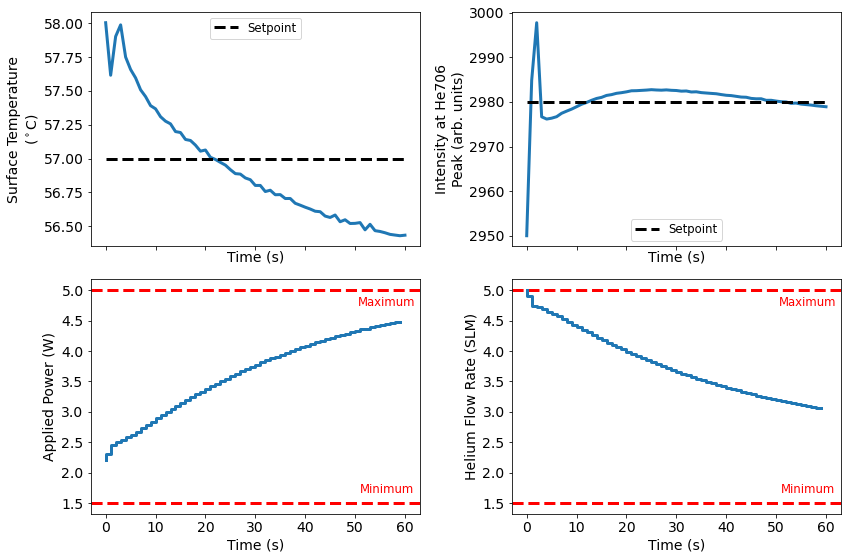



0.01   0.04 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.39559778   0.03360627  -0.02838704]
 [-14.47967377   0.7789153   -0.52600742]
 [ 12.59038939   1.98638335  -1.42915199]]
B:  [[ 2.62414411e+00 -1.89683172e-01]
 [ 4.57976591e+02  5.05317451e+02]
 [ 6.70363327e+02  5.34733645e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
20.0  target penalty applied and exists
Using a MPC.


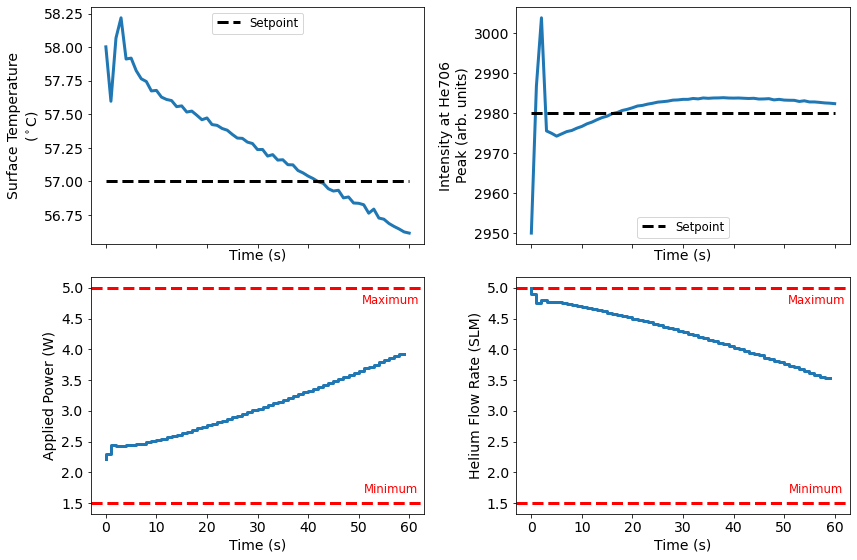



0.01   0.05 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.39559778   0.03360627  -0.02838704]
 [-14.47967377   0.7789153   -0.52600742]
 [ 12.59038939   1.98638335  -1.42915199]]
B:  [[ 2.63663406e+00 -1.90834766e-01]
 [ 4.60467014e+02  5.08739885e+02]
 [ 6.76495724e+02  5.36241492e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
20.0  target penalty applied and exists
Using a MPC.
Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:157:
.../casadi/core/optistack_internal.cpp:998: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use 

Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:157:
.../casadi/core/optistack_internal.cpp:998: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Infeasible_Problem_Detected'
Was not feasible on iteration 57 of simulation
Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:157:
.../casadi/core/optistack_internal.cpp:998: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Infeasible_Problem_Detected'
Was not feasible on iteration 59 of simulation


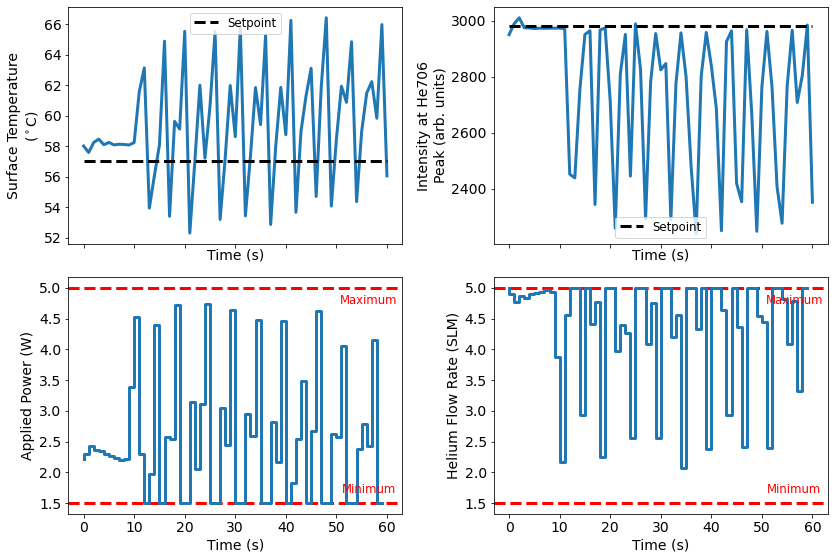



0.02   0.0 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.38959344   0.03360624  -0.02862728]
 [-14.51982692   0.77641709  -0.52747796]
 [ 12.62373795   1.9739538   -1.41659714]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
20.0  target penalty applied and exists
Using a MPC.


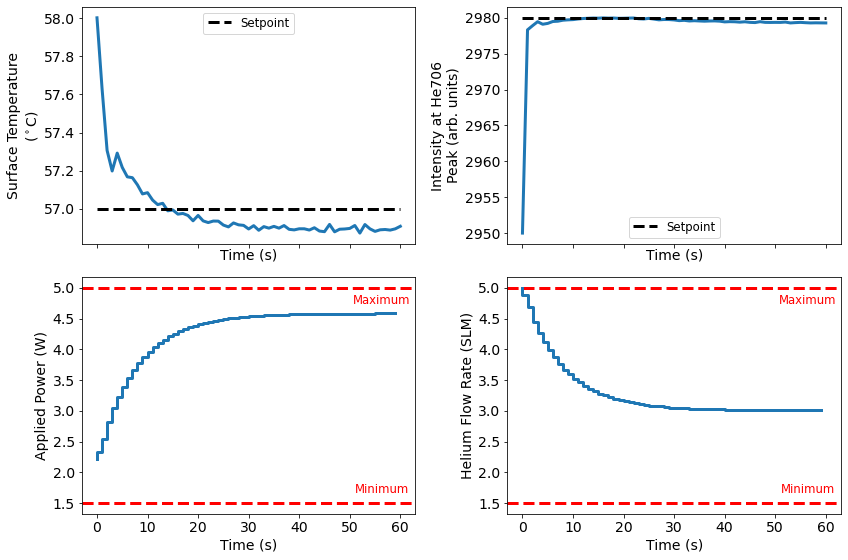



0.02   0.01 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.38959344   0.03360624  -0.02862728]
 [-14.51982692   0.77641709  -0.52747796]
 [ 12.62373795   1.9739538   -1.41659714]]
B:  [[ 2.58667425e+00 -1.86228389e-01]
 [ 4.50505320e+02  4.95050149e+02]
 [ 6.51966136e+02  5.30210103e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
20.0  target penalty applied and exists
Using a MPC.


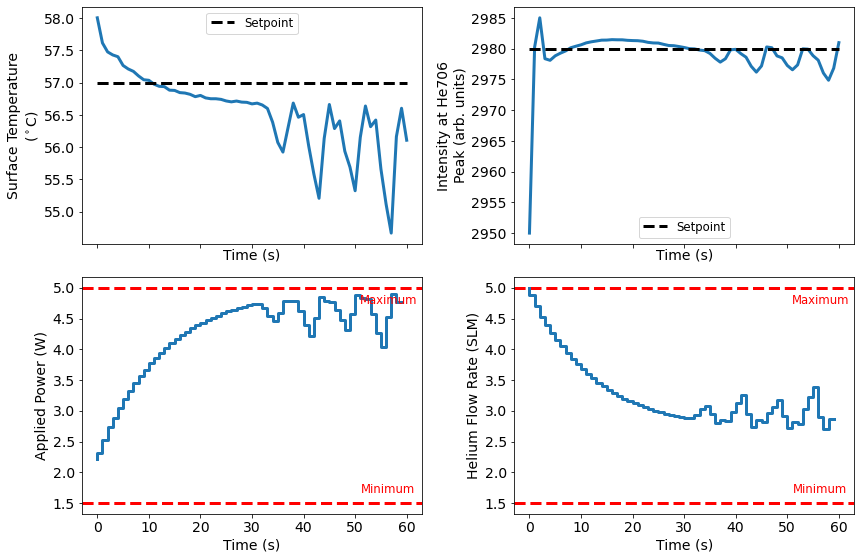



0.02   0.02 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.38959344   0.03360624  -0.02862728]
 [-14.51982692   0.77641709  -0.52747796]
 [ 12.62373795   1.9739538   -1.41659714]]
B:  [[ 2.59916420e+00 -1.87379983e-01]
 [ 4.52995744e+02  4.98472583e+02]
 [ 6.58098533e+02  5.31717950e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
20.0  target penalty applied and exists
Using a MPC.


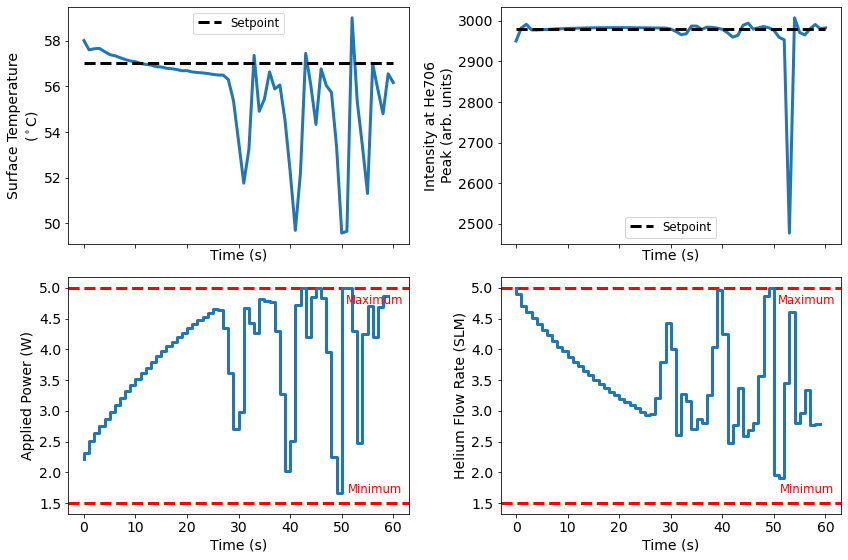



0.02   0.03 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.38959344   0.03360624  -0.02862728]
 [-14.51982692   0.77641709  -0.52747796]
 [ 12.62373795   1.9739538   -1.41659714]]
B:  [[ 2.61165416e+00 -1.88531577e-01]
 [ 4.55486167e+02  5.01895017e+02]
 [ 6.64230930e+02  5.33225798e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
20.0  target penalty applied and exists
Using a MPC.
Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:157:
.../casadi/core/optistack_internal.cpp:998: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use 

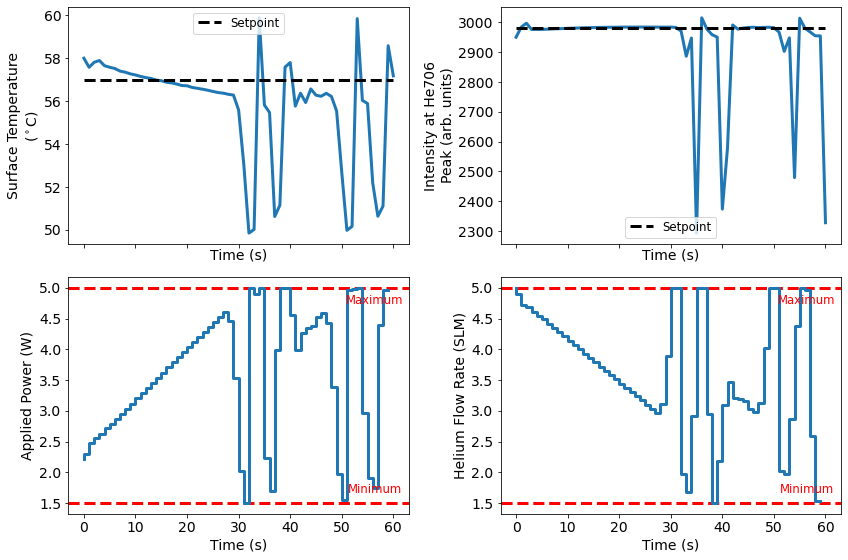



0.02   0.04 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.38959344   0.03360624  -0.02862728]
 [-14.51982692   0.77641709  -0.52747796]
 [ 12.62373795   1.9739538   -1.41659714]]
B:  [[ 2.62414411e+00 -1.89683172e-01]
 [ 4.57976591e+02  5.05317451e+02]
 [ 6.70363327e+02  5.34733645e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
20.0  target penalty applied and exists
Using a MPC.
Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:157:
.../casadi/core/optistack_internal.cpp:998: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use 

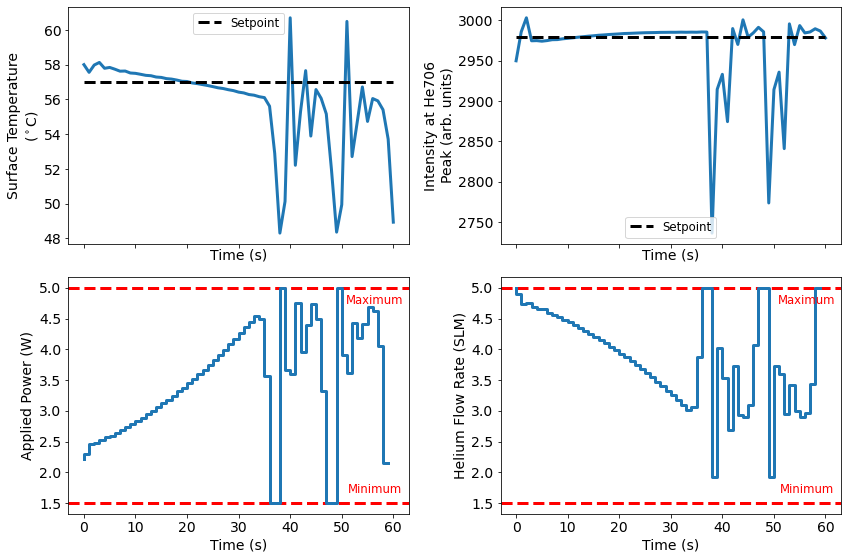



0.02   0.05 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.38959344   0.03360624  -0.02862728]
 [-14.51982692   0.77641709  -0.52747796]
 [ 12.62373795   1.9739538   -1.41659714]]
B:  [[ 2.63663406e+00 -1.90834766e-01]
 [ 4.60467014e+02  5.08739885e+02]
 [ 6.76495724e+02  5.36241492e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
20.0  target penalty applied and exists
Using a MPC.
Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:157:
.../casadi/core/optistack_internal.cpp:998: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use 

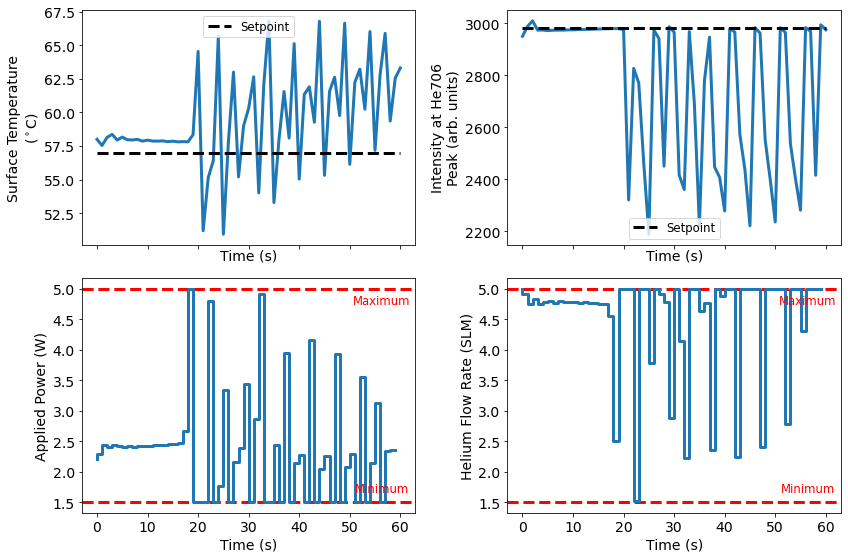



0.03   0.0 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.38358911   0.0336062   -0.02886751]
 [-14.55998006   0.77391889  -0.52894851]
 [ 12.65708651   1.96152425  -1.4040423 ]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
20.0  target penalty applied and exists
Using a MPC.


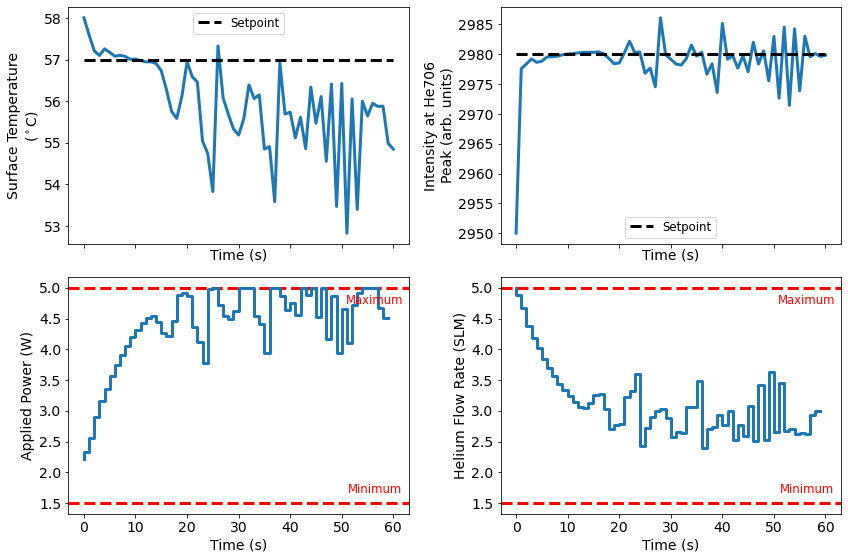



0.03   0.01 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.38358911   0.0336062   -0.02886751]
 [-14.55998006   0.77391889  -0.52894851]
 [ 12.65708651   1.96152425  -1.4040423 ]]
B:  [[ 2.58667425e+00 -1.86228389e-01]
 [ 4.50505320e+02  4.95050149e+02]
 [ 6.51966136e+02  5.30210103e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
20.0  target penalty applied and exists
Using a MPC.


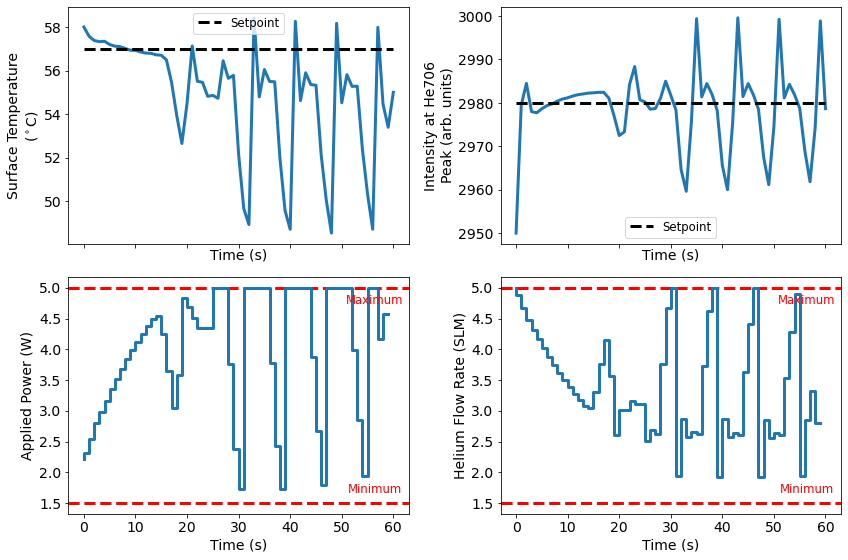



0.03   0.02 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.38358911   0.0336062   -0.02886751]
 [-14.55998006   0.77391889  -0.52894851]
 [ 12.65708651   1.96152425  -1.4040423 ]]
B:  [[ 2.59916420e+00 -1.87379983e-01]
 [ 4.52995744e+02  4.98472583e+02]
 [ 6.58098533e+02  5.31717950e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
20.0  target penalty applied and exists
Using a MPC.


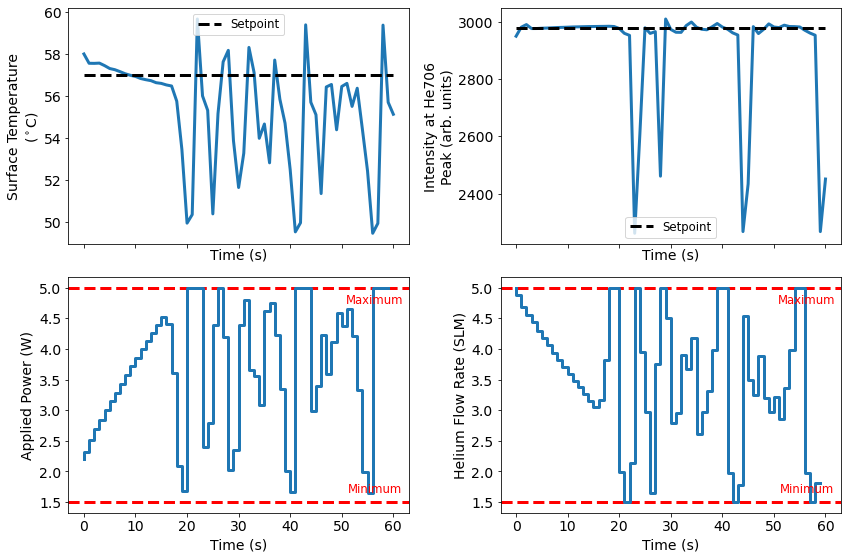



0.03   0.03 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.38358911   0.0336062   -0.02886751]
 [-14.55998006   0.77391889  -0.52894851]
 [ 12.65708651   1.96152425  -1.4040423 ]]
B:  [[ 2.61165416e+00 -1.88531577e-01]
 [ 4.55486167e+02  5.01895017e+02]
 [ 6.64230930e+02  5.33225798e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
20.0  target penalty applied and exists
Using a MPC.


In [ ]:
# testing sensitivity of A and B

for x1 in range(6):
    for x2 in range(6):
        div = 100
        print(x1/div, ' ', x2/div, '\n')
        
        perc = [x1/div,x2/div,0.,seed]
        T, I = run_mpc(perc, plt_fig=True)
        
        print('\n')

# loop through from 0 - 0.1 with stepsize 0.001 and see which values of perc1 and perc2 will not yield an output of infeasible result